# Pip Installs, Import Packages, + Load Data

-   Install and load packages

-   Load WomensSL + event data

In [75]:
 %pip install tqdm statsbombpy -q

Note: you may need to restart the kernel to use updated packages.


In [ ]:
# General Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsbombpy import sb

# Specific imports for this data
from typing import Optional, Iterable
from statsbombpy import sb
from tqdm.auto import tqdm
import math

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

In [77]:
# 2020/2021 Women's Super League (Prem for females)
WomenSL = sb.matches(competition_id=37, season_id=90)

# Print cols + head
print(WomenSL.columns)
WomenSL.sort_values(by='match_week', ascending=True).head()

Index(['match_id', 'match_date', 'kick_off', 'competition', 'season',
       'home_team', 'away_team', 'home_score', 'away_score', 'match_status',
       'match_status_360', 'last_updated', 'last_updated_360', 'match_week',
       'competition_stage', 'stadium', 'referee', 'home_managers',
       'away_managers', 'data_version', 'shot_fidelity_version',
       'xy_fidelity_version'],
      dtype='object')


,match_id,match_date,kick_off,competition,season,home_team,away_team,home_score,away_score,match_status,match_status_360,last_updated,last_updated_360,match_week,competition_stage,stadium,referee,home_managers,away_managers,data_version,shot_fidelity_version,xy_fidelity_version
38,3764234,2020-09-05,15:30:00.000,England - FA Women's Super League,2020/2021,Aston Villa,Manchester City WFC,0,2,available,scheduled,2022-08-15T23:21:21.885827,2021-06-13T16:17:31.694,1,Regular Season,Villa Park,Abigail Byrne,Gemma Davies,Gareth Taylor,1.1.0,2,2
37,3764231,2020-09-06,15:00:00.000,England - FA Women's Super League,2020/2021,Brighton & Hove Albion WFC,Birmingham City WFC,2,0,available,scheduled,2021-07-01T17:59:02.410,2021-06-13T16:17:31.694,1,Regular Season,Broadfield Stadium,Rob Whitton,Hope Patricia Powell,Carla Ward,1.1.0,2,2
32,3764230,2020-09-06,15:00:00.000,England - FA Women's Super League,2020/2021,Tottenham Hotspur Women,West Ham United LFC,1,1,available,scheduled,2020-09-07T23:08:30.613690,2021-06-13T16:17:31.694,1,Regular Season,The Hive Stadium,Kirsty Dowle,Karen Hills,Matt Beard,1.1.0,2,2
26,3764232,2020-09-06,15:30:00.000,England - FA Women's Super League,2020/2021,Manchester United,Chelsea FCW,1,1,available,scheduled,2022-08-15T23:41:02.644315,2021-06-13T16:17:31.694,1,Regular Season,Leigh Sports Village Stadium,Rebecca Welch,Casey Stoney,Emma Hayes,1.1.0,2,2
21,3764233,2020-09-06,13:30:00.000,England - FA Women's Super League,2020/2021,Arsenal WFC,Reading WFC,6,1,available,scheduled,2022-08-15T23:28:49.530360,2021-06-13T16:17:31.694,1,Regular Season,Meadow Park,Amy Fearn,Joseph Montemurro,Kelly Chambers,1.1.0,2,2


In [78]:
# Black box copilot code 

# Load Event Data for Women's Super League

def build_events_dataset(
    matches_df: pd.DataFrame,
    match_id_col: str = "match_id",
    save_csv: Optional[str] = None,
    keep_columns: Optional[Iterable[str]] = None,
    add_meta: bool = True,
    ) -> pd.DataFrame:

# Fetch events for all match_ids in `matches_df`, concatenate into one DataFrame,
# and (optionally) merge key match metadata columns.

# Parameters
# ----------
# matches_df : DataFrame containing at least `match_id`
# match_id_col : name of the match id column
# save_parquet : path to save a Parquet file (recommended)
# save_csv : path to save a CSV file
# keep_columns : iterable of event columns to keep (None = keep all)
# add_meta : merge match metadata columns (season, teams, date, week, competition)

# Returns
# -------
# DataFrame of all events with `match_id` and optional metadata.

    if match_id_col not in matches_df.columns:
        raise KeyError(f"`{match_id_col}` not in matches_df columns")


    meta_cols = [
    match_id_col,
    "season", "season_id", "season_name",
    "competition", "competition_id", "competition_name",
    "match_date", "match_week",
    "home_team", "away_team"
    ]
    meta = matches_df[[c for c in meta_cols if c in matches_df.columns]].drop_duplicates()

    all_frames = []
    failures = []

    mids = pd.unique(matches_df[match_id_col].astype("int64"))
    for mid in tqdm(mids, desc="Fetching events"):
        try:
            ev = sb.events(match_id=int(mid))
            ev[match_id_col] = int(mid)
            all_frames.append(ev)
        except Exception as e:
            failures.append((int(mid), str(e)))

    if not all_frames:
        raise RuntimeError("No events were loaded. Check your match_ids or environment.")

    events = pd.concat(all_frames, ignore_index=True)


    if keep_columns is not None:
        keep = list(set(keep_columns) | {match_id_col})
        events = events[[c for c in keep if c in events.columns]]


    if add_meta and not meta.empty:
        events = events.merge(meta, on=match_id_col, how="left")


    if save_csv:
        events.to_csv(save_csv, index=False)
        print(f"Saved events: {len(events):,} rows → {save_csv}")

    if failures:
        print(f"\n Skipped {len(failures)} matches due to errors (showing first 5):")
    for mid, msg in failures[:5]:
        print(f" match_id={mid}: {msg}")

    return events



events_df = build_events_dataset(
WomenSL,
keep_columns=None,
add_meta=True
)

Fetching events:   0%|          | 0/131 [00:00<?, ?it/s]

# Event Data Cleaning

-   Noticed quite a lot of dummy variables that make data hard to understand. Did some basic feature engineering for some columns and removed cols that I found not helpful for our usecase. Haven't fully worked through entire dataset because I moved onto selecting features we *need* rather than removing ones we don't. Maybe will come back to this.

-   Found the second match of the season on YouTube, helped me to understand what some of the features meant. Link: https://www.youtube.com/watch?v=APK4_kivx6o. Match_id = 3764234. Match starts at 42nd minute of the video. 

In [79]:
# Inspect Event Data Frame Head
pd.set_option('display.max_columns', None)
print(events_df.shape)

# Sort cols alphabetically
events_df = events_df[sorted(events_df.columns)]
events_df.head()

(443304, 122)


,50_50,away_team,bad_behaviour_card,ball_receipt_outcome,ball_recovery_offensive,ball_recovery_recovery_failure,block_deflection,block_offensive,block_save_block,carry_end_location,clearance_aerial_won,clearance_body_part,clearance_head,clearance_left_foot,clearance_other,clearance_right_foot,competition,counterpress,dribble_no_touch,dribble_nutmeg,dribble_outcome,dribble_overrun,duel_outcome,duel_type,duration,foul_committed_advantage,foul_committed_card,foul_committed_offensive,foul_committed_penalty,foul_committed_type,foul_won_advantage,foul_won_defensive,foul_won_penalty,goalkeeper_body_part,goalkeeper_end_location,goalkeeper_lost_in_play,goalkeeper_lost_out,goalkeeper_outcome,goalkeeper_position,goalkeeper_punched_out,goalkeeper_saved_to_post,goalkeeper_shot_saved_off_target,goalkeeper_shot_saved_to_post,goalkeeper_success_in_play,goalkeeper_technique,goalkeeper_type,half_start_late_video_start,home_team,id,index,injury_stoppage_in_chain,interception_outcome,location,match_date,match_id,match_week,minute,miscontrol_aerial_won,off_camera,out,pass_aerial_won,pass_angle,pass_assisted_shot_id,pass_body_part,pass_cross,pass_cut_back,pass_deflected,pass_end_location,pass_goal_assist,pass_height,pass_inswinging,pass_length,pass_miscommunication,pass_no_touch,pass_outcome,pass_outswinging,pass_recipient,pass_recipient_id,pass_shot_assist,pass_straight,pass_switch,pass_technique,pass_through_ball,pass_type,period,play_pattern,player,player_id,position,possession,possession_team,possession_team_id,related_events,season,second,shot_aerial_won,shot_body_part,shot_deflected,shot_end_location,shot_first_time,shot_follows_dribble,shot_freeze_frame,shot_key_pass_id,shot_one_on_one,shot_open_goal,shot_outcome,shot_redirect,shot_saved_off_target,shot_saved_to_post,shot_statsbomb_xg,shot_technique,shot_type,substitution_outcome,substitution_outcome_id,substitution_replacement,substitution_replacement_id,tactics,team,team_id,timestamp,type,under_pressure
0,NaN,Arsenal WFC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,England - FA Women's Super League,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Aston Villa,f51b1630-d1a8-4837-97b0-de862f0e299a,1,NaN,NaN,NaN,2021-02-28,3775648,11,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,Regular Play,NaN,NaN,NaN,1,Aston Villa,2647,NaN,2020/2021,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'formation': 352, 'lineup': [{'player': {'id'...",Aston Villa,2647,00:00:00.000,Starting XI,NaN
1,NaN,Arsenal WFC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,England - FA Women's Super League,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Aston Villa,1bbead8d-7790-4898-a765-3cdffeaf966e,2,NaN,NaN,NaN,2021-02-28,3775648,11,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,Regular Play,NaN,NaN,NaN,1,Aston Villa,2647,NaN,2020/2021,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'formation': 433, 'lineup': [{'player': {'id'...",Arsenal WFC,968,00:00:00.000,Starting XI,NaN
2,NaN,Arsenal WFC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,England - FA Women's Super League,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Aston Villa,ab7e55e6-f6fe-4705-a159-942f8d82c04f,3,NaN,NaN,NaN,2021-02-28,3775648,11,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,Regular Play,NaN,NaN,NaN,1,Aston Villa,2647,[f5d78455-7375-46d4-a414-7580f9f8328a],2020/2021,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Arsenal WFC,968,00:00:00.000,Half Start,NaN
3,NaN,Arsenal WFC,NaN,NaN,NaN,NaN,NaN,Na

## Basic Feature Engineering

In [80]:
# Feature Engineering

# Combine all clearance-related columns into one boolean column — indicates whether *any* clearance occurred
events_df['clearance'] = events_df[['clearance_aerial_won', 'clearance_body_part', 'clearance_head', 'clearance_left_foot', 'clearance_other']].any(axis=1)

# Combine all block-related columns into one boolean column — indicates whether *any* block occurred
events_df['block'] = events_df[['block_deflection', 'block_offensive', 'block_save_block']].any(axis=1)

# Combine goalkeeper type and outcome into a single descriptive column
events_df['goalkeeper_type_outcome'] = events_df['goalkeeper_type'].astype(str) + ' - ' + events_df['goalkeeper_outcome'].astype(str)

# Replace True with descriptive string for fouls committed with advantage
events_df['foul_committed_advantage'] = events_df['foul_committed_advantage'].replace(True, 'Committed Advantage')

# Replace True with descriptive string for offensive fouls committed
events_df['foul_committed_offensive'] = events_df['foul_committed_offensive'].replace(True, 'Committed Offensive')

# Replace True with descriptive string for penalty fouls committed
events_df['foul_committed_penalty'] = events_df['foul_committed_penalty'].replace(True, 'Committed Penalty')

# Replace True with descriptive string for fouls won with advantage
events_df['foul_won_advantage'] = events_df['foul_won_advantage'].replace(True, 'Won Advantage')

# Replace True with descriptive string for fouls won defensively
events_df['foul_won_defensive'] = events_df['foul_won_defensive'].replace(True, 'Won Defensive')

# Replace True with descriptive string for fouls won resulting in penalty
events_df['foul_won_penalty'] = events_df['foul_won_penalty'].replace(True, 'Won Penalty')

# Convert pass angle from radians to degrees and take absolute value since throws from right side are negative
events_df['pass_angle'] = np.abs(events_df['pass_angle'] * 180 / np.pi).round(3)

# Round pass length to 3 decimal places
events_df['pass_length'] = events_df['pass_length'].round(3)

# Round duration to 3 decimal places
events_df['duration'] = events_df['duration'].round(3)

# Remove events that are “Starting XI” or “Half Start”, since these aren’t real plays and don’t represent new possessions
events_df = events_df[~((events_df["type"] == "Starting XI") | (events_df["type"] == "Half Start"))]

# Convert timestamp to timedelta to calc differences
events_df["timestamp"] = pd.to_timedelta(events_df["timestamp"])

# Merge possession_time back into main df, will be repeated for every row in same possession but will make final df much easier to work with
events_df = events_df.merge(
    events_df.groupby(['match_id', 'possession'])['timestamp']
    .apply(lambda x: (x.max() - x.min()).total_seconds())
    .reset_index(name='possession_time'),
    on=['match_id', 'possession'],
    how='left'
)

# Useless columns for possession retention modeling
cols_to_remove = [
    # Match info – all values are useless
    'season', 'competition', 'match_date', 'match_week', 'home_team', 'away_team', 

    # Substitution specifics – irrelevant, whether or not a sub occurs captured in "type" col
    'substitution_replacement', 'substitution_replacement_id', 'substitution_outcome_id', 'substitution_outcome', 

    # Player info – the name or ID of player involved is irrelevant
    'player', 'player_id', 

    # Event ID – we already have match id and can sort chronologically
    'id', 
    'related_events', # long uninterpretable id for related events

    # Tactics / team formation – irrelevant
    'tactics', 

    # Off-camera – col is useless
    'off_camera', 

    # Clearance info – already made generic clearance col
    'clearance_aerial_won', 'clearance_body_part', 'clearance_head', 'clearance_left_foot', 'clearance_right_foot', 'clearance_other', 

    # Block info – already made generic block col
    'block_deflection', 'block_offensive', 'block_save_block', 

    # Goalkeeper info -  either useless or captured in goalkeeper outcome
    'goalkeeper_position', 'goalkeeper_end_location', 'goalkeeper_technique', 'goalkeeper_lost_out', 'goalkeeper_lost_in_play', 
    'goalkeeper_punched_out', 'goalkeeper_saved_to_post','goalkeeper_shot_saved_off_target', 'goalkeeper_shot_saved_to_post', 'goalkeeper_success_in_play',
    'goalkeeper_body_part', 'goalkeeper_type', 'goalkeeper_outcome',

    # Half start late video start, only happened 4 times nothing we can do
    'half_start_late_video_start'
    
]

# Remove columns
events_df_clean = events_df.drop(columns=cols_to_remove)

# Sort df alphabetically
events_df_clean = events_df_clean[sorted(events_df_clean.columns)]

# Sort by match_id then index
events_df_clean = events_df_clean.sort_values(by=['match_id', 'index']).reset_index(drop=True)

# Display cleaned df
pd.set_option('display.max_columns', None)
print(events_df_clean.shape)
events_df_clean.head(10)

(442518, 87)


,50_50,bad_behaviour_card,ball_receipt_outcome,ball_recovery_offensive,ball_recovery_recovery_failure,block,carry_end_location,clearance,counterpress,dribble_no_touch,dribble_nutmeg,dribble_outcome,dribble_overrun,duel_outcome,duel_type,duration,foul_committed_advantage,foul_committed_card,foul_committed_offensive,foul_committed_penalty,foul_committed_type,foul_won_advantage,foul_won_defensive,foul_won_penalty,goalkeeper_type_outcome,index,injury_stoppage_in_chain,interception_outcome,location,match_id,minute,miscontrol_aerial_won,out,pass_aerial_won,pass_angle,pass_assisted_shot_id,pass_body_part,pass_cross,pass_cut_back,pass_deflected,pass_end_location,pass_goal_assist,pass_height,pass_inswinging,pass_length,pass_miscommunication,pass_no_touch,pass_outcome,pass_outswinging,pass_recipient,pass_recipient_id,pass_shot_assist,pass_straight,pass_switch,pass_technique,pass_through_ball,pass_type,period,play_pattern,position,possession,possession_team,possession_team_id,possession_time,second,shot_aerial_won,shot_body_part,shot_deflected,shot_end_location,shot_first_time,shot_follows_dribble,shot_freeze_frame,shot_key_pass_id,shot_one_on_one,shot_open_goal,shot_outcome,shot_redirect,shot_saved_off_target,shot_saved_to_post,shot_statsbomb_xg,shot_technique,shot_type,team,team_id,timestamp,type,under_pressure
0,NaN,NaN,NaN,NaN,NaN,False,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.168,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan - nan,5,NaN,NaN,"[61.0, 40.1]",3764230,0,NaN,NaN,NaN,169.762,NaN,Right Foot,NaN,NaN,NaN,"[38.3, 36.0]",NaN,Ground Pass,NaN,23.067,NaN,NaN,NaN,NaN,Kerys Harrop,15569.0,NaN,NaN,NaN,NaN,NaN,Kick Off,1,From Kick Off,Left Wing,2,Tottenham Hotspur Women,749,14.383,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Tottenham Hotspur Women,749,0 days 00:00:00.218000,Pass,NaN
1,NaN,NaN,NaN,NaN,NaN,False,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan - nan,6,NaN,NaN,"[38.3, 36.0]",3764230,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,From Kick Off,Left Center Back,2,Tottenham Hotspur Women,749,14.383,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Tottenham Hotspur Women,749,0 days 00:00:01.386000,Ball Receipt*,NaN
2,NaN,NaN,NaN,NaN,NaN,False,"[40.9, 37.1]",False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan - nan,7,NaN,NaN,"[38.3, 36.0]",3764230,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,From Kick Off,Left Center Back,2,Tottenham Hotspur Women,749,14.383,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Tottenham Hotspur Women,749,0 days 00:00:01.386000,Carry,NaN
3,NaN,NaN,NaN,NaN,NaN,False,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.797,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan - nan,8,NaN,NaN,"[40.9, 37.1]",3764230,0,NaN,NaN,NaN,25.645,NaN,Left Foot,NaN,NaN,NaN,"[86.1, 58.8]",NaN,High Pass,NaN,50.139,NaN,NaN,Incomplete,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,From Kick Off,Left Center Back,2,Tottenham Hotspur Women,749,14.383,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Tottenham Hotspur Women,749,0 days 00:00:03.406000,Pass,NaN
4,NaN,NaN,NaN,NaN,NaN,False,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,Aerial Lost,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan - nan,9,NaN,NaN,"[86.1, 58.8]",3764230,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,From Kick Off,Center Attacking Midfield,2,Tottenham Hotspur Women,749,14.383,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Tottenham Hotspur Women,749,0 days 00:00:06.203000,Duel,True
5,NaN,NaN,NaN,NaN,NaN,False,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan - nan,10,NaN,NaN,"[34.0, 21.3]",3764230,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,From Kick Off,Left Center Back,2,Totten

## Villa v City Subset

In [81]:
# Only the first match of the season (Villa vs City), sorted by index (chronologically), and only plays related to throw-ins
ThrowsVillaVsCity = (events_df_clean[events_df_clean['match_id'] == 3764234]
                     .sort_values(by='index')
                     .query("pass_type == 'Throw-in'"))

# Selecting cols that I want displayed first
Imp_cols = [
    'index',
    'type',
    'pass_type',
    'pass_outcome',
    'possession_time',
    'location',
    'duration',   
    'timestamp',
    'minute',
    'second',
    'team',
    'pass_angle',
    'pass_end_location',
    'carry_end_location',
    'pass_length',
    'location',
    'goalkeeper_type_outcome'
]

# Display
ThrowsVillaVsCity[Imp_cols + [c for c in ThrowsVillaVsCity.columns if c not in Imp_cols]]

,index,type,pass_type,pass_outcome,possession_time,location,duration,timestamp,minute,second,team,pass_angle,pass_end_location,carry_end_location,pass_length,location,goalkeeper_type_outcome,50_50,bad_behaviour_card,ball_receipt_outcome,ball_recovery_offensive,ball_recovery_recovery_failure,block,clearance,counterpress,dribble_no_touch,dribble_nutmeg,dribble_outcome,dribble_overrun,duel_outcome,duel_type,foul_committed_advantage,foul_committed_card,foul_committed_offensive,foul_committed_penalty,foul_committed_type,foul_won_advantage,foul_won_defensive,foul_won_penalty,injury_stoppage_in_chain,interception_outcome,match_id,miscontrol_aerial_won,out,pass_aerial_won,pass_assisted_shot_id,pass_body_part,pass_cross,pass_cut_back,pass_deflected,pass_goal_assist,pass_height,pass_inswinging,pass_miscommunication,pass_no_touch,pass_outswinging,pass_recipient,pass_recipient_id,pass_shot_assist,pass_straight,pass_switch,pass_technique,pass_through_ball,period,play_pattern,position,possession,possession_team,possession_team_id,shot_aerial_won,shot_body_part,shot_deflected,shot_end_location,shot_first_time,shot_follows_dribble,shot_freeze_frame,shot_key_pass_id,shot_one_on_one,shot_open_goal,shot_outcome,shot_redirect,shot_saved_off_target,shot_saved_to_post,shot_statsbomb_xg,shot_technique,shot_type,team_id,under_pressure
13651,26,Pass,Throw-in,NaN,13.494,"[67.9, 0.1]",1.802,0 days 00:00:39.711000,0,39,Manchester City WFC,149.259,"[45.2, 13.6]",NaN,26.411,"[67.9, 0.1]",nan - nan,NaN,NaN,NaN,NaN,NaN,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3764234,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,High Pass,NaN,NaN,NaN,NaN,Gemma Bonner,15554.0,NaN,NaN,NaN,NaN,NaN,1,From Throw In,Left Back,4,Manchester City WFC,746,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,746,NaN
13781,156,Pass,Throw-in,NaN,78.750,"[51.0, 0.1]",1.679,0 days 00:02:52.567000,2,52,Manchester City WFC,134.566,"[37.9, 13.4]",NaN,18.668,"[51.0, 0.1]",nan - nan,NaN,NaN,NaN,NaN,NaN,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3764234,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Low Pass,NaN,NaN,NaN,NaN,Gemma Bonner,15554.0,NaN,NaN,NaN,NaN,NaN,1,From Throw In,Left Back,10,Manchester City WFC,746,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,746,NaN
14052,427,Pass,Throw-in,NaN,7.714,"[70.2, 80.0]",1.325,0 days 00:08:49.345000,8,49,Manchester City WFC,41.548,"[86.9, 65.2]",NaN,22.314,"[70.2, 80.0]",nan - nan,NaN,NaN,NaN,NaN,NaN,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3764234,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,High Pass,NaN,NaN,NaN,NaN,Georgia Stanway,4643.0,NaN,NaN,NaN,NaN,NaN,1,From Throw In,Right Back,18,Manchester City WFC,746,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,746,NaN
14235,610,Pass,Throw-in,Incomplete,6.107,"[109.8, 80.0]",2.003,0 days 00:13:35.789000,13,35,Manchester City WFC,119.571,"[99.7, 62.2]",NaN,20.466,"[109.8, 80.0]",nan - nan,NaN,NaN,NaN,NaN,NaN,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3764234,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Low Pass,NaN,NaN,NaN,NaN,Samantha June Mewis,5087.0,NaN,NaN,NaN,NaN,NaN,1,From Throw In,Right Wing,27,Manchester City WFC,746,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,746,NaN
14245,620,Pass,Throw-in,NaN,16.770,"[71.1, 80.0]",0.946,0 days 00:13:52.865000,13,52,Manchester City WFC,41.186,"[78.3, 73.7]",NaN,9.567,"[71.1, 80.0]",nan - nan,NaN,NaN,NaN,NaN,NaN,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3764234,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Low Pass,NaN,NaN,NaN,NaN,Janine Elizabeth Beckie,4992.0,NaN,NaN,NaN,NaN,NaN,1,From Throw In,Right Back,28,Manchester City WFC,746,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,746,NaN
14327,702,Pass,Throw-in,NaN,30.557,"[98.9, 80.0]",1.383,0 days 00:16:21.344000,16,21,Aston Villa,152.942,"[85.0, 72.9]",NaN,15.608,"[9

# Throws + Games Dataframes Creation
-   Overall goal is to capture xThrow and xRetain. xThrow is "did your throw go to a teammate yes or no", xRetain is "did you retain possession X amount of seconds after throw in" (original article chose arbitrary number of 7). Throws df will allow us to model both these things, Games df will help us decide if 7 seconds is actually a good baseline for xRetain

**Throws dataframe contains:**  

- `Duration (duration)` – how long it took to take the throw  
- `Location (location)` – where the throw was taken; standardized by team, x=0 is own goal, x=120 is opponent goal  
- `Angle (pass_angle)` – throw angle; throws are considered passes in this dataset  
- `Length (pass_length)` – length of the throw  
- `Outcome (pass_outcome)` – NaN is good, incomplete/out are bad; injury clearance and unknown removed, used for xT (expected throw)  
- `End_Location (pass_end_location)` – where the throw was received  
- `Height (pass_height)` – something *Game of Throw-Ins* didn’t really touch on; assuming higher throws → lower xRetain  
- `Possession_Time (possession_time)` – duration of the possession; will be used for xRetain  
- `Team (team)` – name of the team in possession 
- `Match (match_id)` – primary key for Games df  

**Games dataframe contains:**  

- `Match` – primary key for the dataframe  
- `Team` – team name
- `Outcome` - outcome of game, will help us plot winners with other metrics
- `Total Throws` - total # of throws per match per team
- `#sec_Count` - number of throw-ins resulting in possession greater than # seconds
- `#sec_%` - % of throw-ins resulting in possesion greater than # seconds

In [ ]:
# Throws df for xThrow
Throws = (
    events_df_clean.loc[events_df_clean['pass_type'] == 'Throw-in', ['duration', 'location', 'pass_angle', 'pass_length', 
                                                                     'pass_outcome', 'pass_end_location', 'pass_height', 
                                                                     'possession_time', 'team', 'match_id']]
    .rename(columns={
        'duration' : 'Duration',
        'location' : 'Location',
        'pass_angle' : 'Angle',
        'pass_length' : 'Length',
        'pass_outcome' : 'Outcome',
        'pass_end_location' : 'End_Location',
        'pass_height' : 'Height',
        'possession_time' : 'Possession_Time',
        'team' : 'Team',
        'match_id' : 'Match'
    })
    .reset_index(drop=True)
)

# Drop rows where throw_outcome is Injury Clearance or Unknown, we don't want these for xT and xRetain modeling
Throws = Throws[~Throws['Outcome'].isin(['Injury Clearance', 'Unknown'])].reset_index(drop=True)

# Feature engineering - Third will state whether the throw took place in defensive third, middle third, or attacking third
Throws["Third"] = Throws["Location"].apply(
    lambda loc: (
        "Defensive Third" if loc[0] <= 40
        else "Middle Third" if loc[0] <= 80
        else "Attacking Third"
    )
)

# Wherever outcome isn't NaN, the possession time should be 0 but is actually tracking possession of other team
Throws.loc[Throws['Outcome'].notna(), 'Possession_Time'] = 0.000

# Sort columns alphabetically
Throws = Throws[sorted(Throws.columns)]

Throws.head(15)

,Angle,Duration,End_Location,Height,Length,Location,Match,Outcome,Possession_Time,Team,Third
0,20.758,1.427,"[68.9, 4.8]",High Pass,13.261,"[56.5, 0.1]",3764230,NaN,22.336,Tottenham Hotspur Women,Middle Third
1,4.677,1.713,"[70.1, 78.2]",High Pass,22.074,"[48.1, 80.0]",3764230,Incomplete,0.000,Tottenham Hotspur Women,Middle Third
2,157.292,2.399,"[40.0, 7.8]",Low Pass,19.946,"[58.4, 0.1]",3764230,NaN,22.963,West Ham United LFC,Middle Third
3,150.444,2.029,"[18.9, 9.4]",Low Pass,18.853,"[35.3, 0.1]",3764230,NaN,12.464,West Ham United LFC,Defensive Third
4,9.300,1.674,"[48.7, 75.3]",High Pass,29.082,"[20.0, 80.0]",3764230,NaN,5.375,West Ham United LFC,Defensive Third
5,52.246,1.260,"[48.6, 63.6]",High Pass,20.742,"[35.9, 80.0]",3764230,NaN,14.806,West Ham United LFC,Defensive Third
6,29.197,1.246,"[77.0, 7.7]",Low Pass,15.579,"[63.4, 0.1]",3764230,NaN,4.415,West Ham United LFC,Middle Third
7,41.065,0.973,"[77.0, 71.2]",High Pass,13.396,"[66.9, 80.0]",3764230,NaN,12.422,Tottenham Hotspur Women,Middle Third
8,39.653,0.991,"[25.4, 70.8]",Low Pass,14.417,"[14.3, 80.0]",3764230,NaN,2.198,West Ham United LFC,Defensive Third
9,9.211,1.410,"[62.2, 3.1]",High Pass,18.742,"[43.7, 0.1]",3764230,NaN,2.870,West Ham United LFC,Middle Third


In [106]:
# Games df for xRetain
Games = (
    WomenSL[['match_id', 'home_team', 'away_team', 'home_score', 'away_score']]
    .sort_values(by='match_id',ascending=True)
    .reset_index(drop=True)
)

# Create one col to determine outcome for home team: Win, Lose, or Draw
Games['home_outcome'] = np.select(
    (Games['home_score'] > Games['away_score'],Games['home_score'] < Games['away_score'],Games['home_score'] == Games['away_score']),
    ('Win','Lose','Draw')
)

# Create one col to determine outcome for away team: Win, Lose, or Draw
Games['away_outcome'] = np.select(
    (Games['away_score'] > Games['home_score'],Games['away_score'] < Games['home_score'],Games['away_score'] == Games['home_score']),
    ('Win','Lose','Draw')
)

# Home df
home_df = Games[['match_id', 'home_team', 'home_outcome']].copy()
home_df.rename(columns={'home_team': 'Team', 'home_outcome': 'Outcome', 'match_id': 'Match'}, inplace=True)

# Away df
away_df = Games[['match_id', 'away_team', 'away_outcome']].copy()
away_df.rename(columns={'away_team': 'Team', 'away_outcome': 'Outcome', 'match_id': 'Match'}, inplace=True)

# Combine both dataframes into new
Games = pd.concat([home_df, away_df], ignore_index=True).sort_values(by=['Match', 'Team']).reset_index(drop=True)

# Count number of throw-ins per game per team
throw_counts = Throws.groupby(['Match', 'Team']).size().reset_index(name='Total_Throws')
Games = Games.merge(throw_counts, on=['Match', 'Team'], how='left')

# Loop to compute throw-ins lasting over 1 to 15 seconds
for sec in range(1, 16):
    col_count = f'{sec}sec_Count'
    col_pct = f'{sec}sec_%'
    
    stats = (
        Throws.groupby(['Match', 'Team'])
        .agg(
            Throws_Count=('Angle', 'count'),
            **{col_count: ('Possession_Time', lambda x, s=sec: (x > s).sum())}  # throws lasting > sec
        )
        .reset_index()
    )
    
    stats[col_pct] = (stats[col_count] / stats['Throws_Count'] * 100).round(3)
    
    # Merge into Games dataframe
    Games = Games.merge(stats[['Match', 'Team', col_count, col_pct]], on=['Match', 'Team'], how='left')

Games.head(10)

,Match,Team,Outcome,Total_Throws,1sec_Count,1sec_%,2sec_Count,2sec_%,3sec_Count,3sec_%,4sec_Count,4sec_%,5sec_Count,5sec_%,6sec_Count,6sec_%,7sec_Count,7sec_%,8sec_Count,8sec_%,9sec_Count,9sec_%,10sec_Count,10sec_%,11sec_Count,11sec_%,12sec_Count,12sec_%,13sec_Count,13sec_%,14sec_Count,14sec_%,15sec_Count,15sec_%
0,3764230,Tottenham Hotspur Women,Draw,24,19,79.167,18,75.000,15,62.500,14,58.333,13,54.167,12,50.000,11,45.833,9,37.500,9,37.500,9,37.500,8,33.333,8,33.333,7,29.167,7,29.167,7,29.167
1,3764230,West Ham United LFC,Draw,31,27,87.097,25,80.645,20,64.516,17,54.839,15,48.387,13,41.935,13,41.935,13,41.935,11,35.484,11,35.484,11,35.484,11,35.484,10,32.258,10,32.258,8,25.806
2,3764231,Birmingham City WFC,Lose,26,20,76.923,18,69.231,17,65.385,14,53.846,13,50.000,12,46.154,10,38.462,10,38.462,9,34.615,8,30.769,6,23.077,6,23.077,6,23.077,5,19.231,4,15.385
3,3764231,Brighton & Hove Albion WFC,Win,35,34,97.143,31,88.571,26,74.286,23,65.714,20,57.143,19,54.286,17,48.571,17,48.571,16,45.714,15,42.857,14,40.000,13,37.143,11,31.429,9,25.714,9,25.714
4,3764232,Chelsea FCW,Draw,23,22,95.652,20,86.957,18,78.261,17,73.913,15,65.217,10,43.478,9,39.130,8,34.783,7,30.435,7,30.435,6,26.087,6,26.087,6,26.087,6,26.087,6,26.087
5,3764232,Manchester United,Draw,24,17,70.833,17,70.833,14,58.333,13,54.167,13,54.167,13,54.167,11,45.833,11,45.833,11,45.833,11,45.833,10,41.667,10,41.667,9,37.500,8,33.333,8,33.333
6,3764233,Arsenal WFC,Win,24,21,87.500,20,83.333,16,66.667,14,58.333,14,58.333,13,54.167,12,50.000,11,45.833,11,45.833,11,45.833,10,41.667,9,37.500,8,33.333,7,29.167,7,29.167
7,3764233,Reading WFC,Lose,23,19,82.609,19,82.609,16,69.565,15,65.217,14,60.870,13,56.522,11,47.826,9,39.130,8,34.783,8,34.783,8,34.783,7,30.435,7,30.435,6,26.087,5,21.739
8,3764234,Aston Villa,Lose,20,18,90.000,16,80.000,13,65.000,13,65.000,12,60.000,11,55.000,8,40.000,8,40.000,8,40.000,7,35.000,7,35.000,7,35.000,7,35.000,7,35.000,7,35.000
9,3764234,Manchester City WFC,Win,26,25,96.154,25,96.154,25,96.154,24,92.308,23,88.462,23,88.462,23,88.462,22,84.615,22,84.615,22,84.615,21,80.769,19,73.077,18,69.231,17,65.385,17,65.385


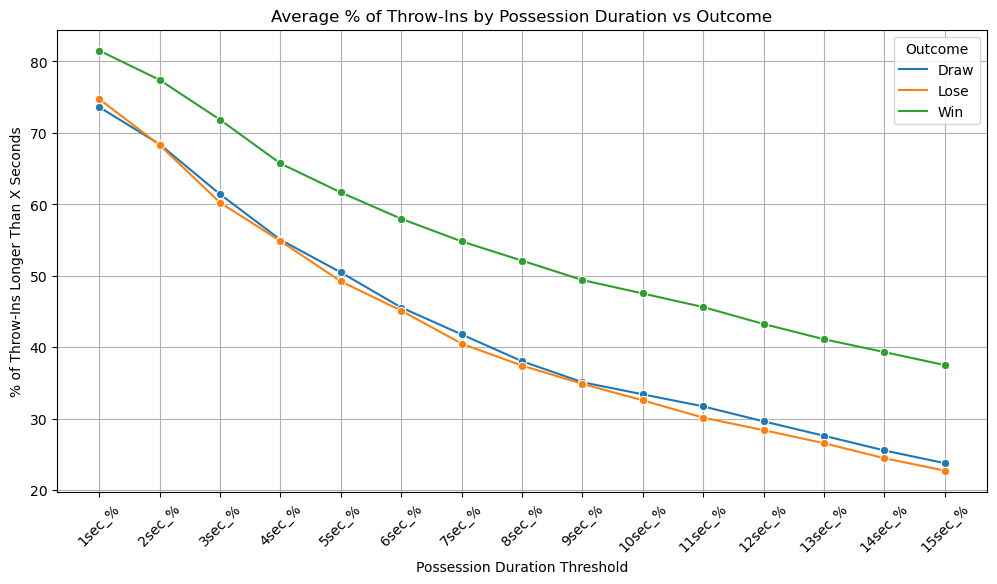

In [ ]:
# Plotting for Games df

# Filter only the % columns
percent_cols = [f'{i}sec_%' for i in range(1, 16)]

# Aggregate by Outcome
agg_df = Games.groupby('Outcome')[percent_cols].mean().reset_index()

# Melt for plotting
plot_df = agg_df.melt(id_vars='Outcome', var_name='Seconds', value_name='Percentage')

# Plot
plt.figure(figsize=(12,6))
sns.lineplot(data=plot_df, x='Seconds', y='Percentage', hue='Outcome', marker='o')
plt.xticks(rotation=45)
plt.title('Average % of Throw-Ins by Possession Duration vs Outcome')
plt.ylabel('% of Throw-Ins Longer Than X Seconds')
plt.xlabel('Possession Duration Threshold')
plt.grid(True)
plt.show()
